In [2]:
import scanpy as sc
import scvi
from matplotlib import rcParams
import matplotlib.pyplot as plt
from liana.method import cellphonedb

folder_path = "C:/Users/heung/OneDrive/Documents/scData/16. Siglec-9_GSE235913/concat/"

In [3]:
# adata = sc.read(folder_path + "adata_annotated.h5ad")
adata_tumor = sc.read(folder_path + "adata_tumor.h5ad")

In [4]:
# adata_myeloid = adata[adata.obs['cell_type'].isin(['Malignant cells'])]
# adata_myeloid.write_h5ad(folder_path + "adata_tumor.h5ad")

# scVI re-clustering

In [4]:
# making the scVI model
# GPU 안쓰면 개느림. Cuda <- 필수

scvi.model.SCVI.setup_anndata(
    adata_tumor,
    layer = 'counts',
    continuous_covariate_keys = ['pct_counts_mito', 'pct_counts_ribo', 'total_counts'],
    batch_key = 'sample'
)
model = scvi.model.SCVI(
    adata_tumor,
    n_layers = 4,
    n_latent = 60,
    gene_likelihood = 'nb',
)

Unable to initialize backend 'cuda': 
Unable to initialize backend 'rocm': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
Unable to initialize backend 'tpu': UNIMPLEMENTED: LoadPjrtPlugin is not implemented on windows yet.
c:\Users\heung\anaconda3\Lib\site-packages\scvi\data\fields\_base_field.py:64: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
c:\Users\heung\anaconda3\Lib\site-packages\scvi\data\fields\_dataframe_field.py:183: UserWarning: Category 74 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.


In [5]:
# model.train(max_epochs = 200)
model.train()   # 28m

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 3070') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\Users\heung\anaconda3\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:441: PossibleUserWarning: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=31` in the `DataLoader` to improve performance.


Epoch 334/334: 100%|██████████| 334/334 [15:17<00:00,  2.75s/it, v_num=1, train_loss_step=5.59e+3, train_loss_epoch=5.68e+3]

`Trainer.fit` stopped: `max_epochs=334` reached.


Epoch 334/334: 100%|██████████| 334/334 [15:17<00:00,  2.75s/it, v_num=1, train_loss_step=5.59e+3, train_loss_epoch=5.68e+3]


In [6]:
# get the latent space
adata_tumor.obsm['X_scVI'] = model.get_latent_representation()
# model.get_latent_representation().shape
# 7.3GB (크게 차이 없음)

# get scVI normalized data
adata_tumor.layers['scvi_normalized'] = model.get_normalized_expression() # <- 용량 큼 (~30GB)

# running time: 5m 25s for 94 samples

# Clustering 결과 확인

In [7]:
# 기본적인 clustering
# sc.pp.pca(adata)
sc.pp.neighbors(adata_tumor, use_rep = 'X_scVI')
sc.tl.umap(adata_tumor)

# running time: 1m 51s
# running time: 2m 23s for 94 samples

In [8]:
sc.tl.leiden(adata_tumor, resolution = 0.5)

C:\Users\heung\AppData\Local\Temp\ipykernel_2380\2949351099.py:1: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.


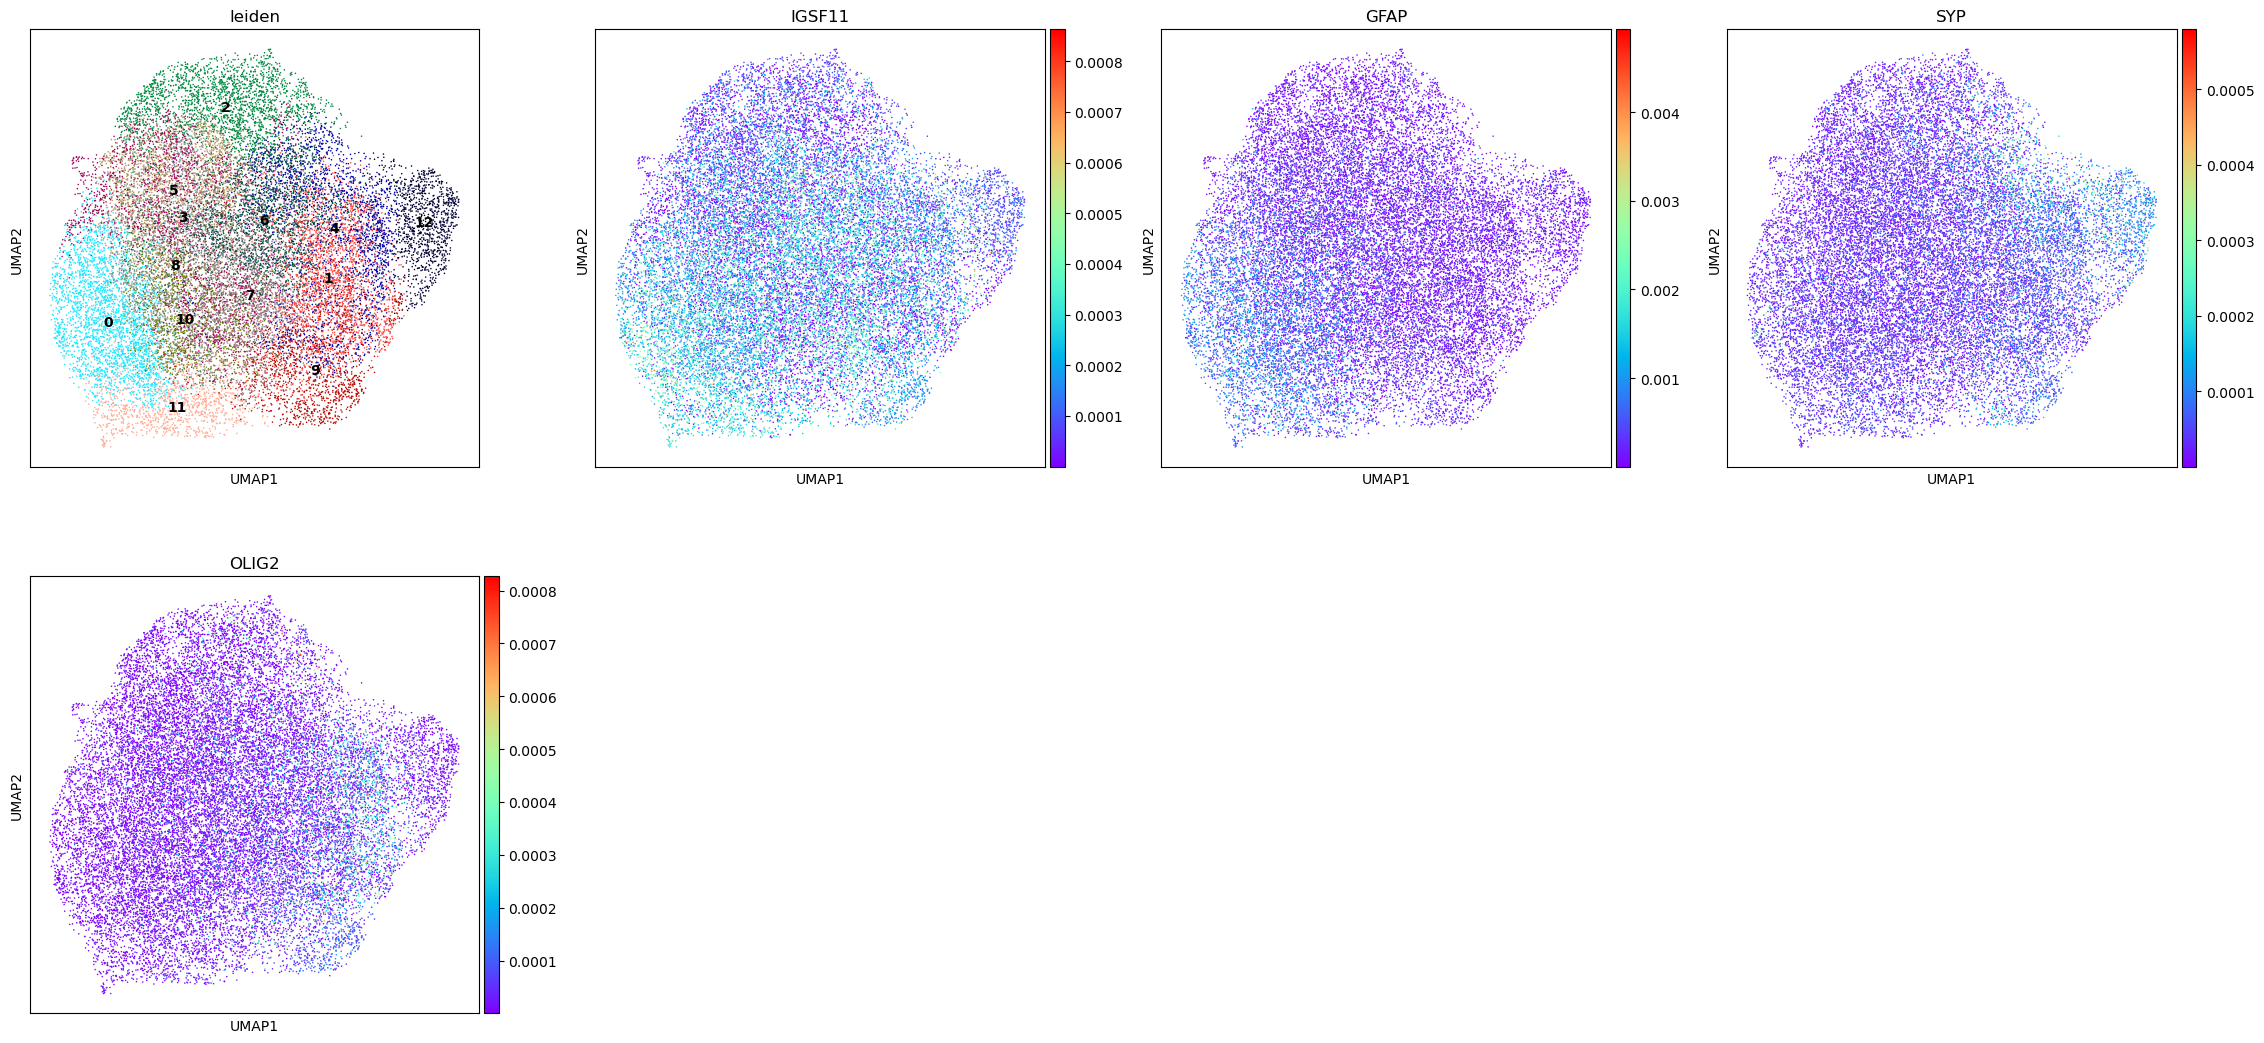

In [15]:
rcParams['figure.figsize'] = (6, 6)

sc.pl.umap(
    adata_tumor,
    color = ['leiden', 'IGSF11', 'GFAP', 'SYP', 'OLIG2'],
    layer = 'scvi_normalized',
    color_map = 'rainbow',
    legend_loc = 'on data',
    # palette = ['red', 'blue']
)

In [17]:
adata_tumor.write_h5ad(folder_path + "adata_tumor.h5ad")
model.save(folder_path + 'model_tumor/')  # trained model 저장